# Predicting Gene Sequence Regenerative Contributions 

By: Jaeyoon Jung, Jeremy Milford, Shree Patel, Cynthia Perez

This notebook develops a model from gene sequences of the axolotl and zebrafish, model regenerative species. This notebook uses feature engineered data to run gridsearch, PCA, and maps the gene data to amino acid sequences to explore biological implications. 

### Necessary Imports

In [1]:
# necessary imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from scipy.stats import ttest_ind
from onehot import onehote

2024-12-09 23:30:06.279280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.threading.set_intra_op_parallelism_threads(2)  # Adjust as needed
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.set_visible_devices([], 'GPU')

Num GPUs Available:  0


In [4]:
features_df = pd.read_csv("gene_sequences.csv")
features_df.head()

,gene_name,sequence_length,gc_content,at_gc_ratio,kmer_3_GGG,kmer_3_GGC,kmer_3_GCG,kmer_3_CGG,kmer_3_GCT,kmer_3_CTG,...,kmer_3_TAG,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA,organism,chromosome,regen,sequence
0,ADIPOQ,1487,0.465367,1.148844,0.014141,0.016162,0.005387,0.005387,0.013468,0.022896,...,0.008754,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CTCAGGAGACCTGGCGATTTTCTCTTCATTCCTGTCTGTACGAGTG...
1,AGTR1A,2286,0.463255,1.158640,0.007881,0.018827,0.005692,0.004378,0.022329,0.029335,...,0.007881,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CCGAGCCTGAGGGTTGGAACCTGCAGAGCAGCGACGCCCCCTAGGC...
2,AGTR2,2861,0.386928,1.584463,0.008395,0.010843,0.001399,0.001749,0.015390,0.023435,...,0.011193,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CCAGAGTCTGGGGATGGAGCGAGCACAGAATTGAAAGCTTTCTTCA...
3,AMTN,1032,0.465116,1.150000,0.011650,0.013592,0.001942,0.001942,0.014563,0.025243,...,0.005825,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,X2,1,AAAAGATAAATTTTGCACCAGAGTAAAGTGGAGAAGTCATCTGGAT...
4,ARHGDIA,89866,0.470211,1.126704,0.016681,0.013810,0.006310,0.007344,0.015112,0.021421,...,0.011440,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,3q,0,TTTCTAGAGCTCTCTTGTGGGACGGGAACTAGATAGACCGGAACTA...


### Test, Train Split

In [5]:
# Drop gene_name and separate features and target 
X = features_df.drop(columns=['gene_name'])
y = (features_df['regen']).astype(int)  
y = y.to_numpy()

# Choose only numeric features for modeling
X_col = X.columns
print(X_col)
X_numeric_features = ["sequence_length", "gc_content", "at_gc_ratio", 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       'kmer_3_ATA', 'kmer_3_GTA', 'kmer_3_TAG', 'kmer_3_CAN', 'kmer_3_ANN',
       'kmer_3_NNN', 'kmer_3_NNT', 'kmer_3_NTA']

X = X.drop(columns = X_numeric_features)
X.head()


Index(['sequence_length', 'gc_content', 'at_gc_ratio', 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       

,organism,chromosome,regen,sequence
0,Rattus norvegicus,2,0,CTCAGGAGACCTGGCGATTTTCTCTTCATTCCTGTCTGTACGAGTG...
1,Rattus norvegicus,2,0,CCGAGCCTGAGGGTTGGAACCTGCAGAGCAGCGACGCCCCCTAGGC...
2,Rattus norvegicus,2,0,CCAGAGTCTGGGGATGGAGCGAGCACAGAATTGAAAGCTTTCTTCA...
3,Rattus norvegicus,X2,1,AAAAGATAAATTTTGCACCAGAGTAAAGTGGAGAAGTCATCTGGAT...
4,Ambystoma mexicanum,3q,0,TTTCTAGAGCTCTCTTGTGGGACGGGAACTAGATAGACCGGAACTA...


In [6]:
# one hot encode each sequence and store in a NumPy array
sequences_ohe = []
for seq in X['sequence']:
    output = onehote(seq)
    if output is None:
        continue
    else:
        sequences_ohe.append(output)

# Pad sequences so they have the same length, but without truncation.
sequences_ohe_padded = pad_sequences(sequences_ohe, padding='post', dtype='float32', value=0)

This train, test split has considered only the numerical features of the data (i.e. no information on organism or chromosome location of the gene)

### CNN on Feature DataFrame

In [7]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    sequences_ohe_padded, y,
    epochs=50,                 # Maximum number of epochs
    batch_size=16,
    validation_split = 0.2,
    callbacks=[early_stopping])  # Add the EarlyStopping callback here

2024-12-09 23:31:10.579631: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4360711712 exceeds 10% of free system memory.


Epoch 1/50


2024-12-09 23:31:24.888874: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4730259456 exceeds 10% of free system memory.


: 

The parameters for this CNN were chosen based on our previous trials in model development. We are seeing early stoppage. Let us consider altering the parameters we are using through GridSearch

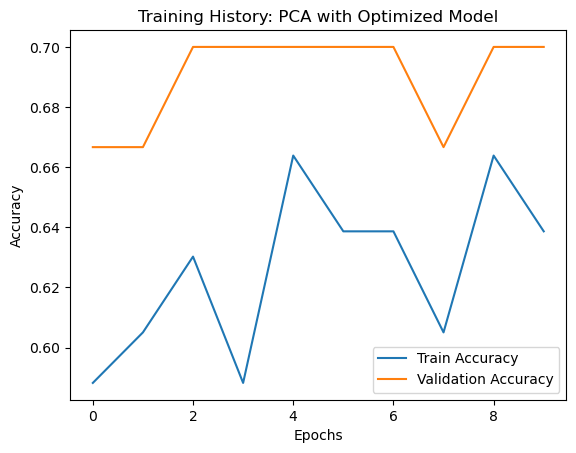

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


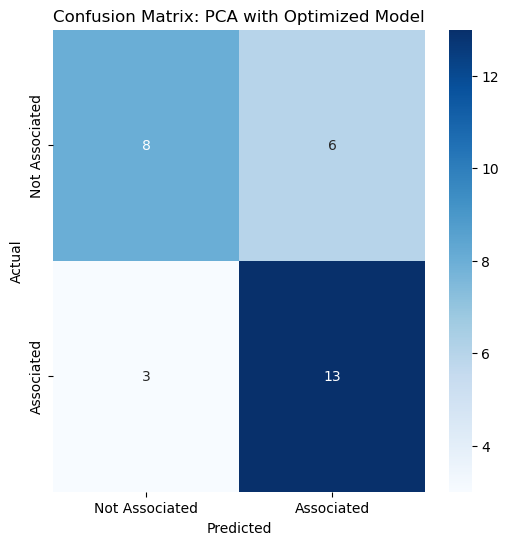

                precision    recall  f1-score   support

Not Associated       0.73      0.57      0.64        14
    Associated       0.68      0.81      0.74        16

      accuracy                           0.70        30
     macro avg       0.71      0.69      0.69        30
  weighted avg       0.70      0.70      0.69        30

Test Accuracy: 0.7


In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: OHE CNN/LSTM")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# this model has no test set, so disregard this cell

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: OHE CNN/LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))